In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


!pip install kaggle

# Assuming your kaggle.json is in your Google Drive
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Example Kaggle API call (replace with your desired command)
!kaggle datasets list

In [ ]:
! kaggle datasets download emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 97% 641M/658M [00:05<00:00, 235MB/s]
100% 658M/658M [00:05<00:00, 132MB/s]


In [ ]:
!unzip plantdisease.zip

In [ ]:
# Import Basic Library
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
folder_path = '/content/PlantVillage'
classes = os.listdir(folder_path)
num_classes = len(classes)
print("Number of classes:", num_classes)
print(classes)

Number of classes: 15
['Potato___Late_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Pepper__bell___healthy', 'Tomato_Leaf_Mold', 'Tomato_healthy', 'Potato___healthy', 'Potato___Early_blight', 'Pepper__bell___Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_mosaic_virus', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Tomato_Early_blight', 'Tomato__Target_Spot']


In [ ]:
class_counts = {}
dataset_path = '/content/PlantVillage'
class_folders = os.listdir(dataset_path)
for class_name in class_folders:
    class_folder_path = os.path.join(dataset_path, class_name)
    class_counts[class_name] = len(os.listdir(class_folder_path))

# Print the number of images per class
for class_name, count in class_counts.items():
    print(f"Class {class_name}: {count} images")

Class Potato___Late_blight: 1000 images
Class Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Class Pepper__bell___healthy: 1478 images
Class Tomato_Leaf_Mold: 952 images
Class Tomato_healthy: 1591 images
Class Potato___healthy: 152 images
Class Potato___Early_blight: 1000 images
Class Pepper__bell___Bacterial_spot: 997 images
Class Tomato__Tomato_YellowLeaf__Curl_Virus: 3209 images
Class Tomato_Septoria_leaf_spot: 1771 images
Class Tomato__Tomato_mosaic_virus: 373 images
Class Tomato_Bacterial_spot: 2127 images
Class Tomato_Late_blight: 1909 images
Class Tomato_Early_blight: 1000 images
Class Tomato__Target_Spot: 1404 images


In [ ]:
# prompt: split the copy the dataset image into test, velidation and training set.

# prompt: split the copy the dataset image into test, velidation and training set.

import os
import shutil
import random

# Define the paths
dataset_path = '/content/PlantVillage'
train_path = '/content/train'
val_path = '/content/val'
test_path = '/content/test'

# Create the directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Iterate through each class
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = os.listdir(class_dir)
    num_images = len(images)

    # Shuffle the images randomly
    random.shuffle(images)

    # Calculate split indices
    train_split = int(num_images * train_ratio)
    val_split = int(num_images * (train_ratio + val_ratio))

    # Create class directories in train, val, and test folders
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

    # Split the images
    for i, image in enumerate(images):
        source_path = os.path.join(class_dir, image)
        if i < train_split:
            destination_path = os.path.join(train_path, class_name, image)
        elif i < val_split:
            destination_path = os.path.join(val_path, class_name, image)
        else:
            destination_path = os.path.join(test_path, class_name, image)
        # Check if it's a file before copying
        if os.path.isfile(source_path):
            shutil.copy(source_path, destination_path)

In [ ]:
# prompt: augment and preprocess the training data for data procesisg

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
img_width, img_height = 224, 224
batch_size = 32

# Create image data generators for training, validation, and test sets with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/val',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating test set
)

Found 14440 images belonging to 15 classes.
Found 3097 images belonging to 15 classes.
Found 3101 images belonging to 15 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model parameters
num_classes = 15
# img_width, img_height = 256, 256

# Initialize the model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(2, 2))

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Third Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Fourth Convoltional Layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
# Flattening
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))

# Dropout to prevent overfitting
model.add(Dropout(0.3))
# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,895,503 (37.75 MB)

 Trainable params: 9,895,503 (37.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# prompt: write code to train the apove tata and validte it

# Train the model
epochs = 10  # You can adjust the number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/451 ━━━━━━━━━━━━━━━━━━━━ 202s 421ms/step - accuracy: 0.2482 - loss: 2.2780 - val_accuracy: 0.4818 - val_loss: 1.5456
Epoch 2/10
  1/451 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.4062 - loss: 1.5492

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4062 - loss: 1.5492 - val_accuracy: 0.4000 - val_loss: 1.6769
Epoch 3/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 186s 407ms/step - accuracy: 0.5672 - loss: 1.2808 - val_accuracy: 0.5267 - val_loss: 1.8098
Epoch 4/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6250 - loss: 1.0653 - val_accuracy: 0.5600 - val_loss: 1.1984
Epoch 5/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 198s 407ms/step - accuracy: 0.7023 - loss: 0.8697 - val_accuracy: 0.7380 - val_loss: 0.7805
Epoch 6/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6875 - loss: 0.8645 - val_accuracy: 0.7600 - val_loss: 0.6641
Epoch 7/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 201s 404ms/step - accuracy: 0.7745 - loss: 0.6455 - val_accuracy: 0.7923 - val_loss: 0.6052
Epoch 8/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.8125 - loss: 0.6176 - val_accuracy: 0.8800 - val_loss: 0.3265
Epoch 9/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 185s 403ms/step - accuracy: 0.8170 - loss: 0.5315 - val_accur

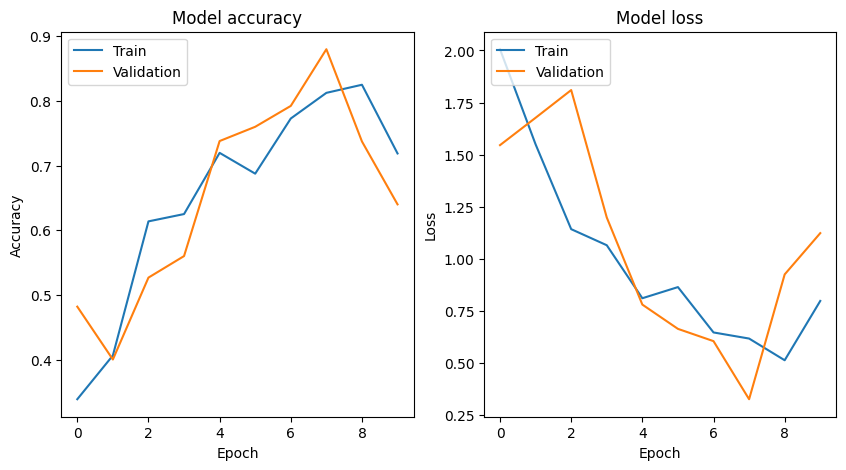

In [ ]:
# prompt: show the loss and accurecy grap

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save('PlantVillage.h5')


Saving powdery-mildew-powdery-mildew-on-squash-leaf-shutterstock-com_13365.webp to powdery-mildew-powdery-mildew-on-squash-leaf-shutterstock-com_13365.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


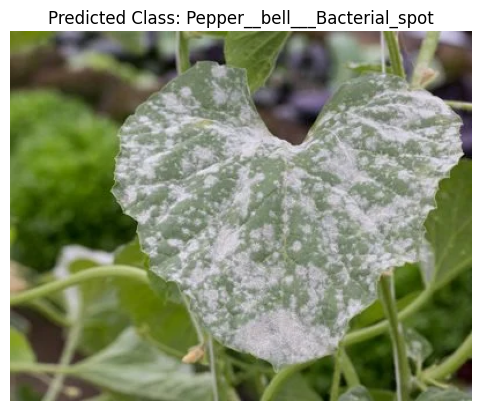

Prediction: Pepper__bell___Bacterial_spot


In [ ]:
# prompt: generate an interface tahat takes input image from user and classify it

from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('PlantVillage.h5')

# Function to preprocess the uploaded image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.  # Normalize the image
    return img_array

# Upload the image from your local machine
uploaded = files.upload()

for fn in uploaded.keys():
    # Preprocess the image
    img_path = fn
    img_array = preprocess_image(img_path)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    # Get class labels (assuming you have them stored in a list)
    class_labels = list(train_generator.class_indices.keys())  # Replace train_generator with your actual generator
    predicted_class = class_labels[predicted_class_index]

    # Display the image and the predicted class
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Prediction: {predicted_class}")